In [ ]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0c5c34693ec14810a19bb35e2f78f4c14a0850f9002ee5e4e07f3b4769851ee8
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.3 MB/s eta 0:00:00


In [1]:
# from pysr import PySRRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# from lime import lime_tabular
# import shap

In [2]:
# Load data
df = pd.read_csv('/content/all_cases_w_clusters.csv') \
      .loc[:, ['Reflectivity','Zdr','Kdp','Rhohv','gauge_precipitation_matched']] \
      .dropna()

df.head()

,Reflectivity,Zdr,Kdp,Rhohv,gauge_precipitation_matched
0,32.035745,0.002344,0.038146,1.002583,1.016
1,32.077695,-0.018490,0.042459,1.000917,1.270
2,17.183210,-0.028255,-0.010754,1.000500,0.508
3,16.943034,0.042578,-0.002402,0.998278,0.508
4,16.657248,0.015625,0.022643,0.996319,0.508


In [ ]:
df2 = pd.read_csv('/content/case3.csv') \
      .loc[:, ['Reflectivity','Zdr','Kdp','Rhohv','gauge_precipitation_matched']] \
      .dropna()

df2.head()

,Reflectivity,Zdr,Kdp,Rhohv,gauge_precipitation_matched
0,7.000000,15.125000,3.970000e-07,0.943333,0.00
63,6.500000,6.093750,9.140000e-07,0.945417,0.00
64,6.500000,7.302083,1.130000e-06,0.957222,0.00
78,15.408756,3.546224,9.688026e-02,0.916944,0.00
79,15.873381,2.625651,8.977057e-02,0.932500,0.25


In [ ]:
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Reflectivity,Zdr,Kdp,Rhohv,gauge_precipitation_matched
0,9.0,6.066761,-0.164934,0.944242,0.0
1,9.0,6.276989,-0.002573,0.932879,0.0
2,7.0,5.557812,0.014453,0.941667,0.0
3,7.0,4.899306,0.014454,0.929444,0.0
4,7.0,4.955078,0.014455,0.926250,0.0


In [ ]:
df.shape

(2677, 5)

In [ ]:
# Counting negative values in each column
negative_counts = df.apply(lambda x: (x < 0).sum())
print(negative_counts)

Reflectivity                     7
Zdr                            461
Kdp                            532
Rhohv                            0
gauge_precipitation_matched      0
dtype: int64


In [ ]:
df.isnull().sum()

,0
Reflectivity,0
Zdr,0
Kdp,0
Rhohv,0
gauge_precipitation_matched,0


#SR based Symbolic model

In [13]:
class SymbolicModel(nn.Module):
    def __init__(self):
        super(SymbolicModel, self).__init__()
        self.a = nn.Parameter(torch.tensor([0.850], dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor([0.482], dtype=torch.float32))
        self.c = nn.Parameter(torch.tensor([10.925], dtype=torch.float32))

    def forward(self, Zdr, Kdp, Z):
        # Example symbolic equation with learnable parameters
        intermediate_result = (self.a ** Zdr) * Z * (Kdp + self.b) - self.c
        if torch.isnan(intermediate_result).any():
            intermediate_result = torch.nan_to_num(intermediate_result, nan=0.0)
        return torch.abs(intermediate_result)

# Empirical based symbolic model

In [3]:
class SymbolicModel(nn.Module):
    def __init__(self):
        super(SymbolicModel, self).__init__()

        self.a_zh = nn.Parameter(torch.tensor(0.0170, dtype=torch.float32))
        self.b_zh = nn.Parameter(torch.tensor(0.7143, dtype=torch.float32))

        self.a_kdp = nn.Parameter(torch.tensor(40.5, dtype=torch.float32))
        self.b_kdp = nn.Parameter(torch.tensor(0.85, dtype=torch.float32))

        self.a_zh_zdr = nn.Parameter(torch.tensor(0.0067, dtype=torch.float32))
        self.b_zh_zdr = nn.Parameter(torch.tensor(0.927, dtype=torch.float32))
        self.c_zh_zdr = nn.Parameter(torch.tensor(-0.343, dtype=torch.float32))

        self.a_kdp_zdr = nn.Parameter(torch.tensor(90.8, dtype=torch.float32))
        self.b_kdp_zdr = nn.Parameter(torch.tensor(0.93, dtype=torch.float32))
        self.c_kdp_zdr = nn.Parameter(torch.tensor(-0.169, dtype=torch.float32))

    def forward(self, ZDR, KDP, ZH):
        output = self.calculate_output(ZDR, KDP, ZH)
        output = torch.nan_to_num(output, nan=0.0)
        return output

    def calculate_output(self, ZDR, KDP, ZH):
        cond1 = (KDP >= 0.3) & (ZH >= 38)
        cond2 = (KDP < 0.3)

        output = torch.zeros_like(ZH)

        # Apply R(KDP, ZDR) or R(KDP) based on ZDR
        output[cond1 & (ZDR >= 0.5)] = self.R_KDP_ZDR(KDP[cond1 & (ZDR >= 0.5)], ZDR[cond1 & (ZDR >= 0.5)])
        output[cond1 & (ZDR < 0.5)] = self.R_KDP(KDP[cond1 & (ZDR < 0.5)])

        # Apply R(ZH, ZDR) or R(ZH) based on ZDR
        output[cond2 & (ZDR >= 0.5)] = self.R_ZH_ZDR(ZH[cond2 & (ZDR >= 0.5)], ZDR[cond2 & (ZDR >= 0.5)])
        output[cond2 & (ZDR < 0.5)] = self.R_ZH(ZH[cond2 & (ZDR < 0.5)])

        return output

    def R_ZH(self, ZH):
        return self.a_zh * torch.pow(ZH, self.b_zh)

    def R_KDP(self, KDP):
        return self.a_kdp * torch.pow(KDP, self.b_kdp)

    def R_ZH_ZDR(self, ZH, ZDR):

        return self.a_zh_zdr * ZH.pow(self.b_zh_zdr) * torch.pow(10, self.c_zh_zdr * ZDR)

    def R_KDP_ZDR(self, KDP, ZDR):
        return self.a_kdp_zdr * torch.pow(KDP, self.b_kdp_zdr) * torch.pow(10, self.c_kdp_zdr * ZDR)


In [4]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # 4 inputs for Reflectivity, Zdr, Kdp, Rhohv
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output a single value: precipitation rate (gauge_precipitation_matched)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation, direct output for regression
        return x

In [14]:
class NeuroSymbolicModel(nn.Module):
    def __init__(self):
        super(NeuroSymbolicModel, self).__init__()
        self.neural_net = SimpleNeuralNetwork()
        self.symbolic_net = SymbolicModel()

    def forward(self, x):
        # Predict using the neural network component
        neural_pred = self.neural_net(x)

        # Predict using the symbolic component
        symbolic_pred = self.symbolic_net(x[:, 1], x[:, 2], x[:, 0])

        return neural_pred, symbolic_pred


In [6]:
# Combining Losses
def custom_loss_and_combine(neural_pred, symbolic_pred, target, should_print=True, neural_weight=1):
    criterion = nn.MSELoss()

    # Calculate individual losses
    loss_symbolic = criterion(symbolic_pred, target)
    loss_neural = criterion(neural_pred, target)


    # Apply the maximum neural network weight threshold
    if neural_weight != 1:
        Wd = neural_weight
        Ws = 1 - Wd
        Ws = torch.tensor(Ws, dtype=torch.float32)
        Wd = torch.tensor(Wd, dtype=torch.float32)

    elif neural_weight == 1:
        # Calculate weights inversely proportional to losses
      Ws = 1 / loss_symbolic
      Wd = 1 / loss_neural
      Wsum = Ws + Wd
      Ws = Ws / Wsum
      Wd = Wd / Wsum

    ### Print weights
    if should_print:
      print(f"Weights for Combined Loss - Symbolic: {Ws}, Neural: {Wd}")

    # Calculate combined prediction
    R_combined = Ws * symbolic_pred + Wd * neural_pred

    # Combined loss for backpropagation (could use either as the main loss or a combination)
    combined_loss = Ws * loss_symbolic + Wd * loss_neural

    return combined_loss, loss_symbolic, loss_neural, R_combined, Ws, Wd

In [8]:
# Praparing data

features = df[['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']]
target = df['gauge_precipitation_matched']


In [9]:
## Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)


In [10]:
# Convert to Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# # If the target is expected to be a 2D tensor (e.g., [N, 1] where N is number of samples)
# y_train_tensor = y_train_tensor.unsqueeze(1)
# y_test_tensor = y_test_tensor.unsqueeze(1)


# Training

### for Dynamic weighting : neural_weight= 1
### for Static weighting : neural_weight != 1  

In [15]:
model = NeuroSymbolicModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Gradual Learning ####

# # Initially, set requires_grad to False for symbolic parameters
# for param in model.symbolic_net.parameters():
#     param.requires_grad = False

# # After some epochs, start updating symbolic parameters
# def unfreeze_symbolic_parameters(epoch):
#     if epoch >= 0:  # Example threshold
#         for param in model.symbolic_net.parameters():
#             param.requires_grad = True



epochs = 700
losses = []
symbolic_losses = []
neural_losses = []
weights_storage = {'symbolic': [], 'neural': []}
print(weights_storage)


# Training loop
for epoch in range(epochs):
    # unfreeze_symbolic_parameters(epoch)
    optimizer.zero_grad()

    # Forward pass to get predictions
    neural_pred, symbolic_pred = model(X_train_tensor)

    should_print = (epoch % 10 == 0)

    # Calculate custom loss and get combined predictions
    loss, loss_symbolic, loss_neural, combined_pred, Ws, Wd = custom_loss_and_combine(neural_pred.squeeze(), symbolic_pred, y_train_tensor, should_print, neural_weight=1)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses for plotting
    losses.append(loss.item())
    symbolic_losses.append(loss_symbolic.item())
    neural_losses.append(loss_neural.item())

    # Store weights
    weights_storage['symbolic'].append(Ws.item())
    weights_storage['neural'].append(Wd.item())

    if epoch % 100 == 0:
        print(symbolic_pred.isnan().sum())
        print(f"Epoch {epoch}, Combined Loss: {loss.item()}, Symbolic Loss: {loss_symbolic.item()}, Neural Loss: {loss_neural.item()}")


{'symbolic': [], 'neural': []}
Weights for Combined Loss - Symbolic: 0.8132713437080383, Neural: 0.18672865629196167
tensor(0)
Epoch 0, Combined Loss: 48.517295837402344, Symbolic Loss: 29.828479766845703, Neural Loss: 129.9138946533203
Weights for Combined Loss - Symbolic: 0.7192323207855225, Neural: 0.28076764941215515
Weights for Combined Loss - Symbolic: 0.7223333716392517, Neural: 0.2776666581630707
Weights for Combined Loss - Symbolic: 0.7155293226242065, Neural: 0.28447064757347107
Weights for Combined Loss - Symbolic: 0.7150060534477234, Neural: 0.2849939465522766
Weights for Combined Loss - Symbolic: 0.7141094207763672, Neural: 0.2858906388282776
Weights for Combined Loss - Symbolic: 0.7128076553344727, Neural: 0.28719237446784973
Weights for Combined Loss - Symbolic: 0.7113264799118042, Neural: 0.2886734902858734
Weights for Combined Loss - Symbolic: 0.7092147469520569, Neural: 0.2907853126525879
Weights for Combined Loss - Symbolic: 0.7063002586364746, Neural: 0.293699741363

In [ ]:
weights_storage['symbolic'][-1], weights_storage['neural'][-1]

(0.2592407464981079, 0.7407591938972473)

In [ ]:
# Assuming `model` is an instance of SymbolicModel that has been trained
print("Learned parameters of the Symbolic Model:")
print(f"a_zh: {model.symbolic_net.a_zh.item()}")
print(f"b_zh: {model.symbolic_net.b_zh.item()}")

print(f"a_kdp: {model.symbolic_net.a_kdp.item()}")
print(f"b_kdp: {model.symbolic_net.b_kdp.item()}")

print(f"a_zh_zdr: {model.symbolic_net.a_zh_zdr.item()}")
print(f"b_zh_zdr: {model.symbolic_net.b_zh_zdr.item()}")
print(f"c_zh_zdr: {model.symbolic_net.c_zh_zdr.item()}")

print(f"a_kdp_zdr: {model.symbolic_net.a_kdp_zdr.item()}")
print(f"b_kdp_zdr: {model.symbolic_net.b_kdp_zdr.item()}")
print(f"c_kdp_zdr: {model.symbolic_net.c_kdp_zdr.item()}")


Learned parameters of the Symbolic Model:
a_zh: nan
b_zh: nan
a_kdp: 40.86505126953125
b_kdp: 0.5780478715896606
a_zh_zdr: 0.1513487547636032
b_zh_zdr: 1.188355803489685
c_zh_zdr: -0.24500496685504913
a_kdp_zdr: 90.6391830444336
b_kdp_zdr: 0.9677543044090271
c_kdp_zdr: -0.24748767912387848


In [ ]:
# Save the model
torch.save(model.state_dict(), 'neuro_symbolic_model.pth')

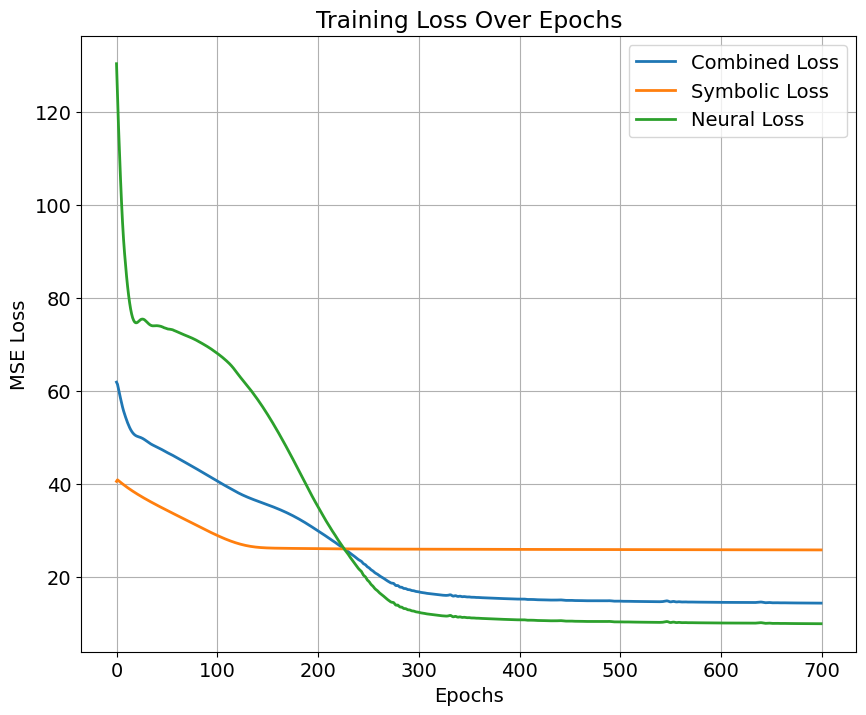

In [12]:
# Plotting the results

# Increase the font sizes and line width
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2})

plt.figure(figsize=(10, 8))
plt.plot(losses, label='Combined Loss')
plt.plot(symbolic_losses, label='Symbolic Loss')
plt.plot(neural_losses, label='Neural Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
weights_storage['neural']


[0.14552196860313416,
 0.1512216478586197,
 0.15662206709384918,
 0.1615178883075714,
 0.16565680503845215,
 0.16891779005527496,
 0.17152664065361023,
 0.17344626784324646,
 0.17465578019618988,
 0.17510263621807098,
 0.17505478858947754,
 0.17469315230846405,
 0.17417682707309723,
 0.173664391040802,
 0.17327852547168732,
 0.17308993637561798,
 0.1731170415878296,
 0.17333851754665375,
 0.17370842397212982,
 0.17417438328266144,
 0.17470505833625793,
 0.1752387285232544,
 0.17565786838531494,
 0.175951287150383,
 0.17609357833862305,
 0.17610633373260498,
 0.17603880167007446,
 0.1759515106678009,
 0.1758960485458374,
 0.1759028285741806,
 0.175979882478714,
 0.1761191040277481,
 0.1763017475605011,
 0.17650467157363892,
 0.17670868337154388,
 0.1769184023141861,
 0.17715442180633545,
 0.1772051453590393,
 0.17731168866157532,
 0.17748424410820007,
 0.1775646209716797,
 0.17765603959560394,
 0.17775537073612213,
 0.1778624951839447,
 0.17798112332820892,
 0.17811450362205505,
 0.1782

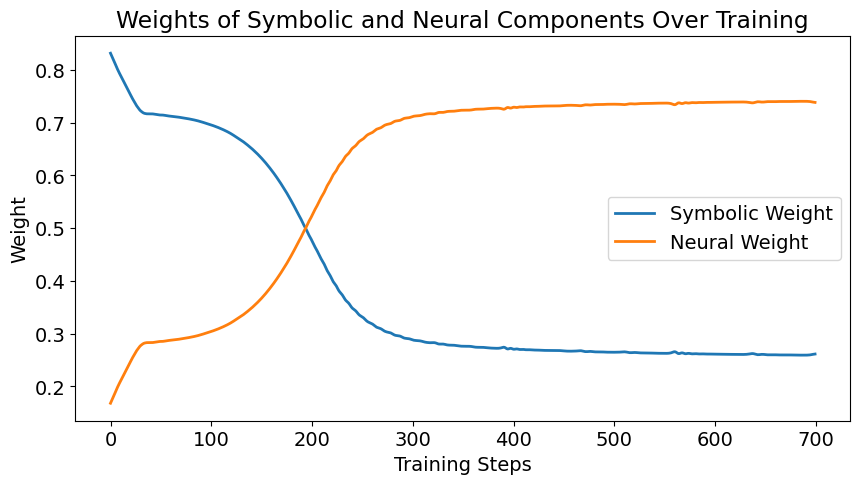

In [ ]:
# Plotting the results

plt.figure(figsize=(10, 5))
plt.plot(weights_storage['symbolic'], label='Symbolic Weight')
plt.plot(weights_storage['neural'], label='Neural Weight')
plt.xlabel('Training Steps')
plt.ylabel('Weight')
plt.title('Weights of Symbolic and Neural Components Over Training')
plt.legend()
plt.show()

In [ ]:
X_train

,Reflectivity,Zdr,Kdp,Rhohv
2043,23.119660,0.275347,-0.009698,1.016778
3477,19.189988,0.420312,0.014452,1.015167
1525,29.141288,0.144271,-0.037903,0.995167
819,41.159339,0.600000,0.381440,0.987167
3373,42.640809,1.028212,0.444197,0.980417
...,...,...,...,...
4466,30.591834,0.730903,0.016254,0.992593
479,43.448996,0.565625,0.378806,0.921167
3132,34.539148,0.491753,0.092908,0.993148
3812,10.803741,1.495833,-0.001568,0.982111


#SHAP XAI method

In [ ]:
weights_storage['neural'][-1]

0.7712581157684326

In [ ]:
filtered_X_test = X_test[(X_test['Zdr'] > 0.5) & (X_test['Kdp'] > 0.3)]
filtered_X_test

,Reflectivity,Zdr,Kdp,Rhohv
897,43.815630,0.744792,0.518636,0.992139
360,47.833783,0.918750,1.087077,0.987833
761,40.381993,0.726563,0.337926,0.988667
2824,43.959990,0.941840,0.670373,0.989630
23,42.684649,0.748437,0.500682,0.991583
2207,41.762904,1.050781,0.559655,0.986944
899,44.775055,0.790104,0.462750,0.990972
2874,40.238854,1.086372,0.426330,0.957593
2576,41.028947,0.769531,0.472704,0.985833
784,42.930402,0.668750,0.363141,0.901667


In [ ]:
weights_storage['neural'][-1]

0.7250717282295227

In [ ]:
weights_storage['symbolic'][-1]

0.2749282717704773

In [ ]:

# Assume symbolic_model and neural_model are your models for symbolic and neural predictions
def combined_model_predict(data):
    # Convert data to tensor if it's not already one (ensure it matches your model input requirements)
    data_tensor = torch.tensor(data, dtype=torch.float32)

    model.eval()  # Set the model to evaluation mode
    # Model predictions
    data_tensor = torch.tensor(data, dtype=torch.float32)

    neural_pred, symbolic_pred = model(data_tensor)

    target = y_train_tensor

    # _, _, _, combined_pred, _, _ = custom_loss_and_combine(neural_pred.squeeze(), symbolic_pred, target, should_print=True)

    #Combined prediction based on the latest weights
    combined_pred = (weights_storage['neural'][-1] * neural_pred.squeeze() + weights_storage['symbolic'][-1] * symbolic_pred)

    return combined_pred.detach().numpy()



In [ ]:
explainer = shap.KernelExplainer(model=combined_model_predict, data=X_train)


In [ ]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/469 [00:00<?, ?it/s]

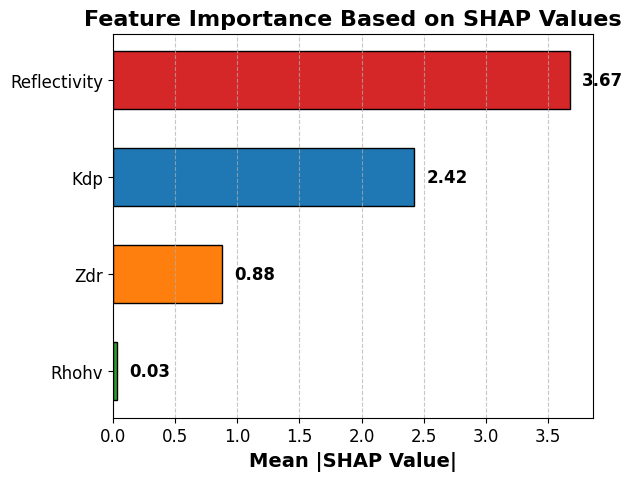

In [ ]:
mean_shap_values = np.abs(shap_values).mean(axis=0)
# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

In [ ]:
shap_values.shape

(41, 4)

In [ ]:
# Plot SHAP values for the first test instance
shap.initjs()  # Initialize JavaScript visualization in Jupyter notebook
shap.force_plot(explainer.expected_value, shap_values, filtered_X_test)

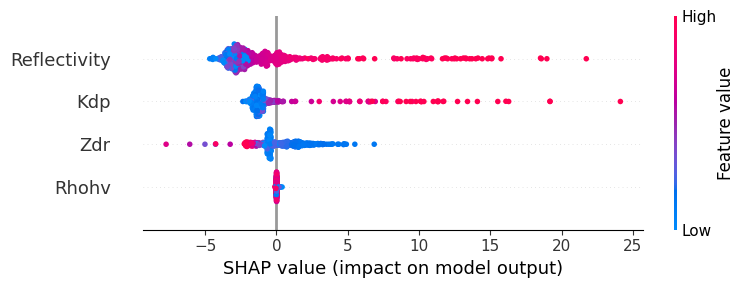

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
# mean_shap_values = np.abs(shap_values).mean(axis=0)

In [ ]:
mean_shap_values

array([3.62998576, 0.93235768, 2.06855249, 0.04388405])

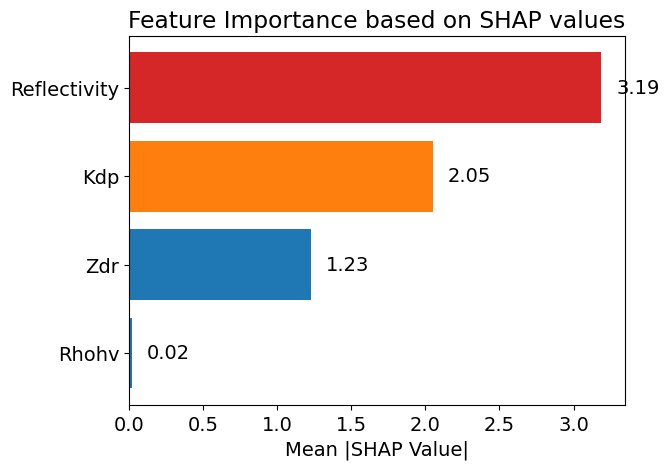

In [ ]:
mean_shap_values = np.abs(shap_values).mean(axis=0)

features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
colors = ['#D62728', '#FF7F0E', '#1F77B4', '#1F77B4']


sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]
colors_sorted = np.array(colors)[sorted_indices]

# Create a horizontal bar plot
plt.barh(features_sorted, mean_shap_values_sorted, color=colors)

# Add SHAP values as text labels on the bars
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center')

# Add labels and title
plt.xlabel('Mean |SHAP Value|')
plt.title('Feature Importance based on SHAP values')

plt.gca().invert_yaxis()

# Display the plot
plt.show()

In [ ]:
# Assuming ZDR, KDP, ZH are columns in your X_test DataFrame
ZDR = X_test['Zdr']
KDP = X_test['Kdp']
ZH = X_test['Reflectivity']

# Define conditions
cond1 = (KDP >= 0.3) & (ZH >= 38)
cond2 = (KDP < 0.3)

# Apply the conditions and separate the data
# First subset: cond1 and ZDR >= 0.5
subset1 = X_test[cond1 & (ZDR >= 0.5)]

# Second subset: cond1 and ZDR < 0.5
subset2 = X_test[cond1 & (ZDR < 0.5)]

# Third subset: cond2 and ZDR >= 0.5
subset3 = X_test[cond2 & (ZDR >= 0.5)]

# Fourth subset: cond2 and ZDR < 0.5
subset4 = X_test[cond2 & (ZDR < 0.5)]

  0%|          | 0/41 [00:00<?, ?it/s]

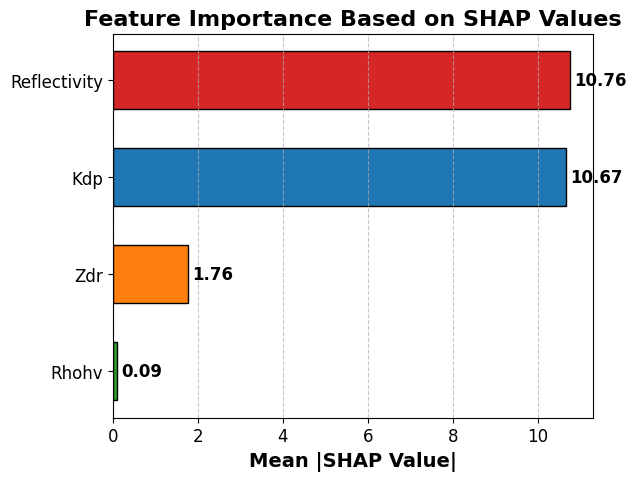

In [ ]:
shap_values_1 = explainer.shap_values(subset1)
mean_shap_values = np.abs(shap_values_1).mean(axis=0)

# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()


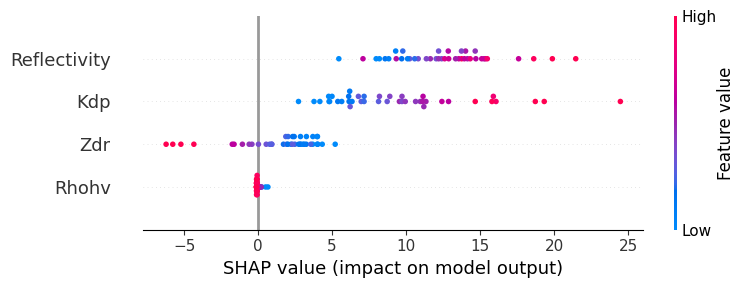

In [ ]:
shap.summary_plot(shap_values_1, subset1)

  0%|          | 0/6 [00:00<?, ?it/s]

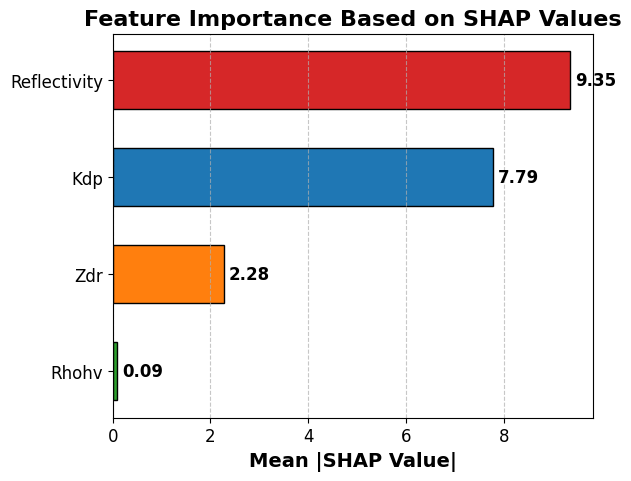

In [ ]:
shap_values_2 = explainer.shap_values(subset2)
mean_shap_values = np.abs(shap_values_2).mean(axis=0)

# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

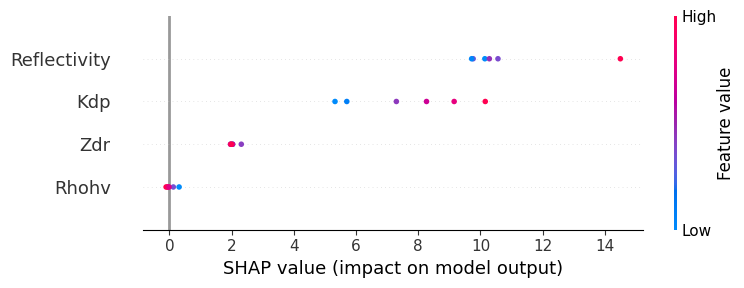

In [ ]:
shap.summary_plot(shap_values_2, subset2)

  0%|          | 0/260 [00:00<?, ?it/s]

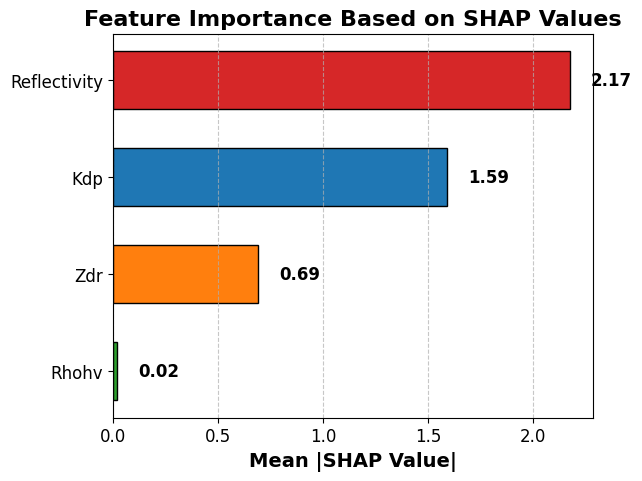

In [ ]:
shap_values_3 = explainer.shap_values(subset3)
mean_shap_values = np.abs(shap_values_3).mean(axis=0)

# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

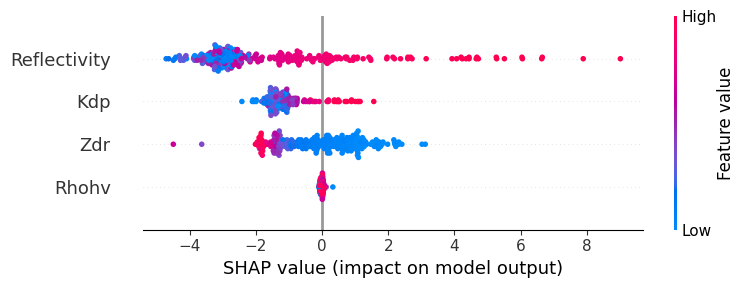

In [ ]:
shap.summary_plot(shap_values_3, subset3)

  0%|          | 0/158 [00:00<?, ?it/s]

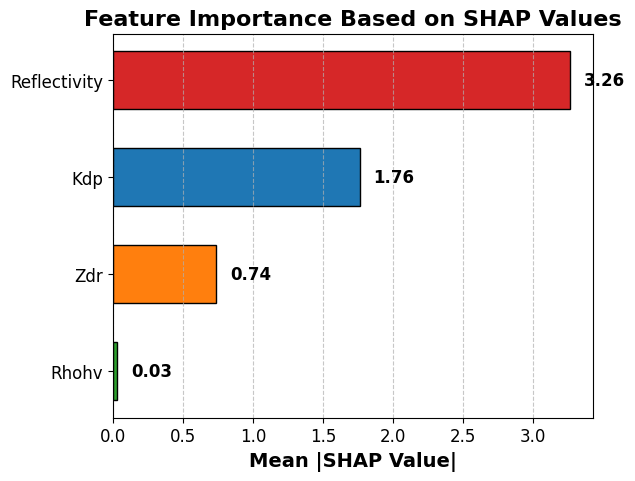

In [ ]:
shap_values_4 = explainer.shap_values(subset4)
mean_shap_values = np.abs(shap_values_4).mean(axis=0)
# Define features and a dictionary with fixed colors for each feature
features = ['Reflectivity', 'Zdr', 'Kdp', 'Rhohv']
color_map = {'Reflectivity': '#D62728', 'Zdr': '#FF7F0E', 'Kdp': '#1F77B4', 'Rhohv': '#2CA02C'}  # Fixed colors

# Sort SHAP values and features based on the mean SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]
mean_shap_values_sorted = mean_shap_values[sorted_indices]
features_sorted = np.array(features)[sorted_indices]

# Get corresponding fixed colors for each feature
colors_sorted = [color_map[feature] for feature in features_sorted]

# Create a horizontal bar plot with increased bar width for better visibility
plt.barh(features_sorted, mean_shap_values_sorted, color=colors_sorted, edgecolor='black', height=0.6)

# Add SHAP values as text labels on the bars with enhanced visibility
for i, v in enumerate(mean_shap_values_sorted):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=12, fontweight='bold')

# Add labels and title with larger font sizes
plt.xlabel('Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.title('Feature Importance Based on SHAP Values', fontsize=16, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert y-axis to have the highest SHAP values at the top
plt.gca().invert_yaxis()

# Add grid for better readability of SHAP values
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add padding around the plot for better spacing
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

# Display the plot
plt.show()

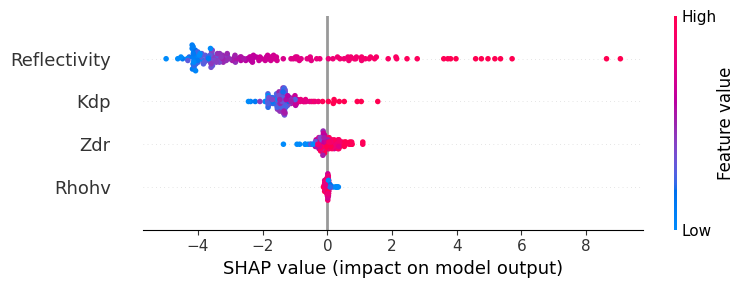

In [ ]:
shap.summary_plot(shap_values_4, subset4)

## Setting Local Interpretable Model-agnostic Explanations (LIME)

In [ ]:
### Prepare Model and Data for LIME

def ex_model_predict(data):

  data_tensor = torch.tensor(data, dtype=torch.float32)

  neural_pred, symbolic_pred = model(data_tensor)

  # _, _, _, combined_pred, _, _ = custom_loss_and_combine(neural_pred.squeeze(), symbolic_pred, y_train_tensor, should_print=True)
  # Combine predictions if necessary; here, simply return them without combining if that's the model's behavior
  combined_pred = (neural_pred.squeeze() + symbolic_pred) / 2
  # combined_pred = neural_pred.squeeze()

  return combined_pred.detach().numpy()

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  # Convert DataFrame to numpy array if needed
    feature_names=X_train.columns.tolist(),  # Get feature names from DataFrame
    mode='regression'
)

In [ ]:
test_pred = ex_model_predict(X_test.iloc[0].values.reshape(1, -1))
print("Test Prediction Output:", test_pred)

Test Prediction Output: 4.7116513


In [ ]:
# Choose an instance to explain
instance = instance = X_test.iloc[0].values.reshape(1, -1)  # Adjust indexing if needed
print(instance.shape)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn = ex_model_predict,  # Your prediction function
    num_features = 4  # Number of features to include in the explanation
)

# Visualize the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

(1, 4)


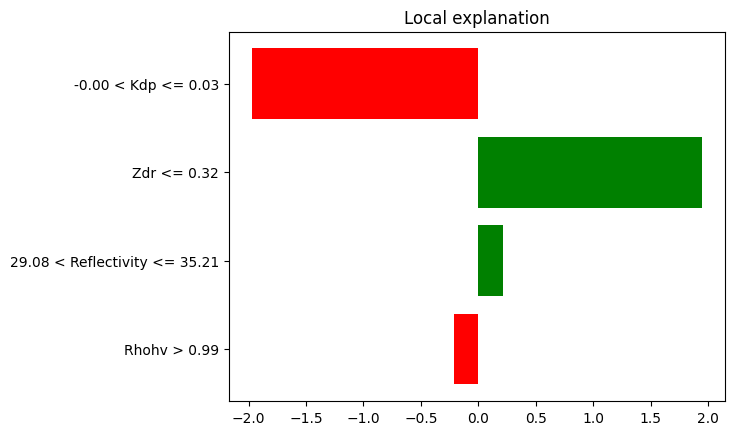

In [ ]:
%matplotlib inline
fig = explanation.as_pyplot_figure()

#Testing the model

In [ ]:
weights_storage['neural'][-1], weights_storage['symbolic'][-1]

(0.7812946438789368, 0.21870540082454681)

In [16]:
# testing the model

model.eval()  # Set the model to evaluation mode

# Prepare to collect predictions and actual labels
W_neural = weights_storage['neural'][-1]
all_predictions = []
all_targets = []

with torch.no_grad(): # Turn off gradients for validation, saves memory and computations

  # Forward pass to get outputs
  neural_pred, symbolic_pred = model(X_test_tensor)

  # Optional: Combine the predictions (if needed, based on your setup)
  # Assuming you want to review both or use a custom combination rule as during training
  _, _, _, combined_pred,_ , _ = custom_loss_and_combine(neural_pred.squeeze(), symbolic_pred, y_test_tensor , neural_weight= W_neural)

  # Store predictions and targets for later analysis
  all_predictions.extend(combined_pred.tolist())
  all_targets.extend(y_test_tensor.tolist())

Weights for Combined Loss - Symbolic: 0.2581615447998047, Neural: 0.7418384552001953


In [18]:
W_n = weights_storage['neural'][-1]
W_s = weights_storage['symbolic'][-1]
mse = mean_squared_error(y_test_tensor.numpy(), combined_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), combined_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), combined_pred.numpy())
bias = np.mean(combined_pred.numpy()) - np.mean(y_test_tensor.numpy())

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absulute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Bias: {bias}")

print(f"& {W_n:.1f} & {W_s:.1f} & {mae:.3f} & {rmse:.3f} & {r2:.2f} & {bias:.3f}")


Mean Squared Error: 8.349950790405273
Root Mean Squared Error: 2.8896281719207764
Mean Absulute Error: 1.865612506866455
R^2 Score: 0.9065291954424073
Bias: 0.5965042114257812
& 0.7 & 0.3 & 1.866 & 2.890 & 0.91 & 0.597


# only Symbolic

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_tensor.numpy(), combined_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), combined_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), combined_pred.numpy())
bias = np.mean(combined_pred.numpy()) - np.mean(y_test_tensor.numpy())


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absulute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Bias: {bias}")

Mean Squared Error: 26.491779327392578
Root Mean Squared Error: 5.147016525268555
Mean Absulute Error: 3.066606044769287
R^2 Score: 0.7034464167477634
Bias: -1.7113642692565918


# Static weighting (ws:0.9, wd:0.1)

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_tensor.numpy(), combined_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), combined_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), combined_pred.numpy())
bias = np.mean(combined_pred.numpy()) - np.mean(y_test_tensor.numpy())


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absulute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Bias: {bias}")

print(f"& 0.1 & 0.9 & 1.503 & 2.676 & 0.91 & 0.060")

Mean Squared Error: 8.098653793334961
Root Mean Squared Error: 2.845813274383545
Mean Absulute Error: 1.5496596097946167
R^2 Score: 0.9093422533664752
Bias: -0.1901540756225586


# Static weighting (ws:0.6, wd:0.4)

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_tensor.numpy(), combined_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), combined_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), combined_pred.numpy())
bias = np.mean(combined_pred.numpy()) - np.mean(y_test_tensor.numpy())


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absulute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Bias: {bias}")

Mean Squared Error: 8.18781852722168
Root Mean Squared Error: 2.861436367034912
Mean Absulute Error: 1.5378156900405884
R^2 Score: 0.9083441274665021
Bias: -0.1978135108947754


#Static weighting (ws:0.5, wd:0.5)

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_tensor.numpy(), combined_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), combined_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), combined_pred.numpy())
bias = np.mean(combined_pred.numpy()) - np.mean(y_test_tensor.numpy())


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absulute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Bias: {bias}")

Mean Squared Error: 8.061861991882324
Root Mean Squared Error: 2.839341878890991
Mean Absulute Error: 1.5459415912628174
R^2 Score: 0.9097541158223607
Bias: -0.30225133895874023


# Dynamic weighting



In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_tensor.numpy(), combined_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), combined_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), combined_pred.numpy())
bias = np.mean(combined_pred.numpy()) - np.mean(y_test_tensor.numpy())


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absulute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Bias: {bias}")

Mean Squared Error: 7.9534125328063965
Root Mean Squared Error: 2.8201794624328613
Mean Absulute Error: 1.518120527267456
R^2 Score: 0.9109681187531018
Bias: -0.20649003982543945


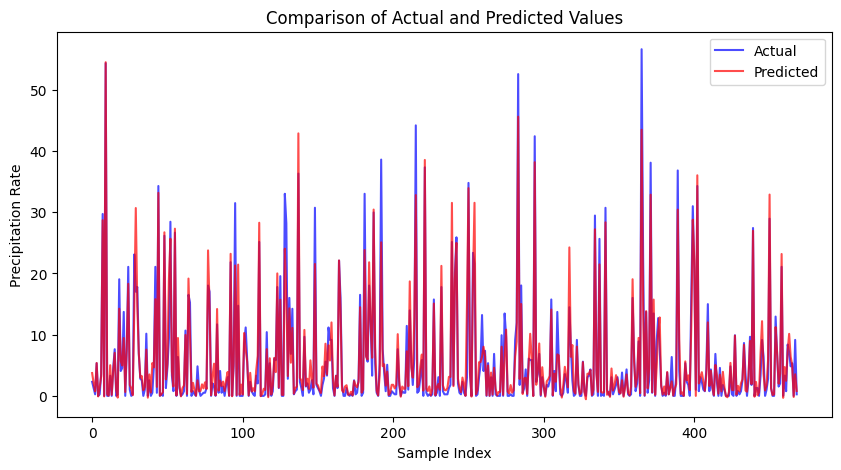

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_tensor.numpy(), label='Actual', color='blue', alpha=0.7)
plt.plot(combined_pred.numpy(), label='Predicted', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Precipitation Rate')
plt.legend()
plt.show()


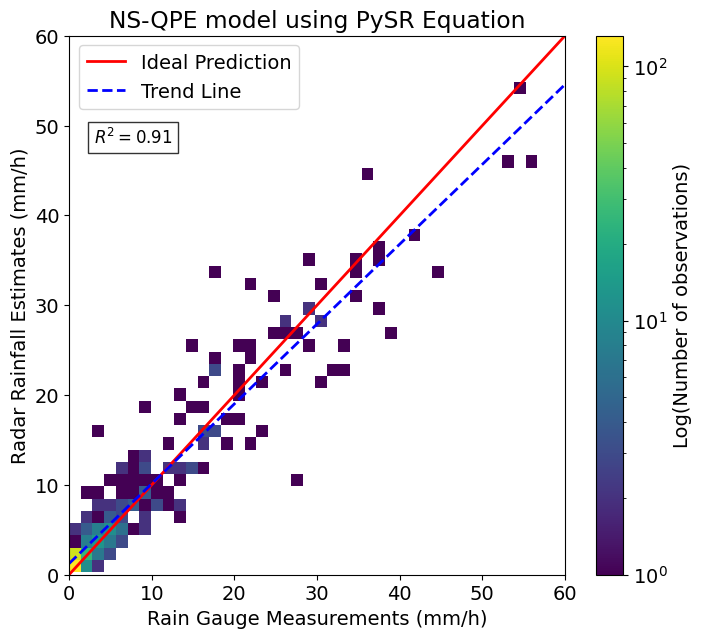

In [19]:
from matplotlib.colors import LogNorm

# Convert tensors to numpy arrays if they aren't already
actual = y_test_tensor.numpy()
predicted = combined_pred.numpy()


# Create a 2D histogram / heatmap
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2})

plt.figure(figsize=(8, 7))
h, xedges, yedges, image = plt.hist2d(actual, predicted, bins=40, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Log(Number of observations)')

# Diagonal line indicating perfect prediction
plt.plot([0, 60], [0, 60], 'r', label='Ideal Prediction')

# Calculate trend line
coefficients = np.polyfit(actual, predicted, 1)  # Linear fit (1st degree polynomial)
trendline = np.poly1d(coefficients)  # Create a polynomial function with these coefficients
x_trend = np.linspace(0, 60, 100)  # Generate x-values for your trendline, adjust range as needed
plt.plot(x_trend, trendline(x_trend), "b--", label='Trend Line')  # Plot trend line

plt.xlabel('Rain Gauge Measurements (mm/h)')
plt.ylabel('Radar Rainfall Estimates (mm/h)')
plt.title('NS-QPE model using PySR Equation')
plt.xlim(0, 60)  # Adjust according to your data range
plt.ylim(0, 60)  # Adjust according to your data range
plt.grid(False)  # Disable grid lines
plt.legend()

# Show the R^2 score on the plot
plt.text(3, 48, f'$R^2 = {r2:.2f}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.8), zorder=5)
plt.show()


TypeError: Colorbar.__init__() got an unexpected keyword argument 'fontsize'

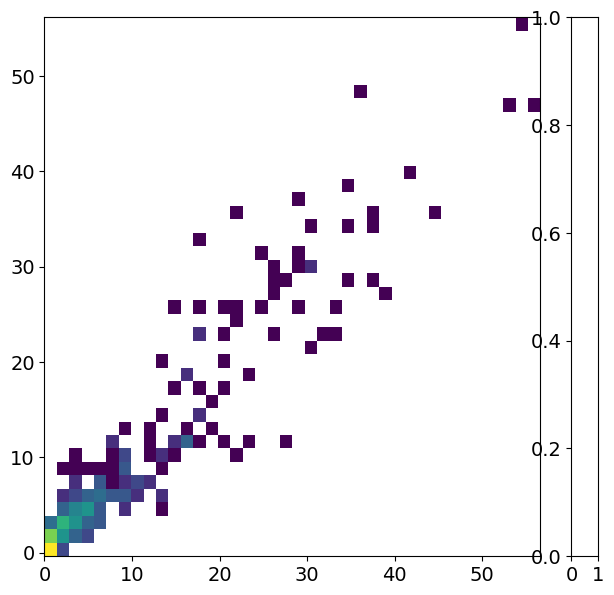

In [ ]:


# Convert tensors to numpy arrays if they aren't already
actual = y_test_tensor.numpy()
predicted = combined_pred.numpy()

# Set larger font sizes using rcParams
plt.rcParams.update({'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 16,
                     'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14})

plt.figure(figsize=(8, 7))

# Create a 2D histogram / heatmap
h, xedges, yedges, image = plt.hist2d(actual, predicted, bins=40, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Log(Number of observations)', fontsize=14)  # Set fontsize for colorbar

# Diagonal line indicating perfect prediction
plt.plot([0, 60], [0, 60], 'r', label='Ideal Prediction', linewidth=2)

# Calculate trend line
coefficients = np.polyfit(actual, predicted, 1)  # Linear fit (1st degree polynomial)
trendline = np.poly1d(coefficients)  # Create a polynomial function with these coefficients
x_trend = np.linspace(0, 60, 100)  # Generate x-values for your trendline, adjust range as needed
plt.plot(x_trend, trendline(x_trend), "b--", label='Trend Line', linewidth=2)  # Plot trend line

# Labels and title with adjusted font sizes
plt.xlabel('Rain Gauge Measurements (mm/h)', fontsize=16)
plt.ylabel('Radar Rainfall Estimates (mm/h)', fontsize=16)
plt.title('NS Model using PySR Equation', fontsize=18)

# Set axis limits
plt.xlim(0, 60)  # Adjust according to your data range
plt.ylim(0, 60)  # Adjust according to your data range

# Customize grid and legend
plt.grid(False)  # Disable grid lines
plt.legend(fontsize=14)

# Show the R^2 score on the plot with larger font size
plt.text(3, 48, f'$R^2 = {r2:.2f}$', fontsize=16, bbox=dict(facecolor='white', alpha=0.8), zorder=5)

# Show the plot
plt.show()


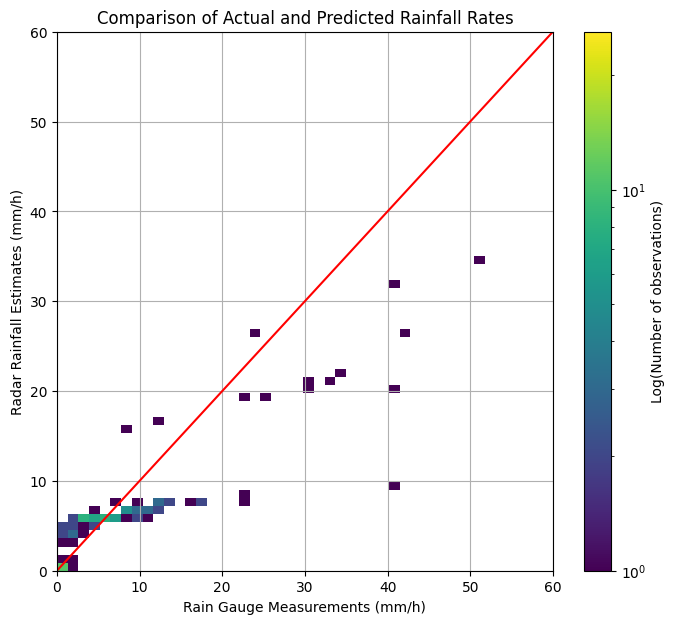

In [ ]:
from matplotlib.colors import LogNorm

# Convert tensors to numpy arrays if they aren't already
actual = y_test_tensor.numpy()
predicted = combined_pred.numpy()

# Create a 2D histogram / heatmap
plt.figure(figsize=(8, 7))
h, xedges, yedges, image = plt.hist2d(actual, predicted, bins=40, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Log(Number of observations)')
plt.plot([0, 60], [0, 60], 'r')  # Diagonal line

plt.xlabel('Rain Gauge Measurements (mm/h)')
plt.ylabel('Radar Rainfall Estimates (mm/h)')
plt.title('Comparison of Actual and Predicted Rainfall Rates')
plt.xlim(0, 60)  # Adjust according to your data range
plt.ylim(0, 60)  # Adjust according to your data range
plt.grid(True)
plt.show()